Deep Learning
=============

Assignment 1
------------

The objective of this assignment is to learn about simple data curation practices, and familiarize you with some of the data we'll be reusing later.

This notebook uses the [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) dataset to be used with python experiments. This dataset is designed to look like the classic [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, while looking a little more like real data: it's a harder task, and the data is a lot less 'clean' than MNIST.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

First, we'll download the dataset to our local machine. The data consists of characters rendered in a variety of fonts on a 28x28 image. The labels are limited to 'A' through 'J' (10 classes). The training set has about 500k and the testset 19000 labelled examples. Given these sizes, it should be possible to train models quickly on any machine.

In [2]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Extract the dataset from the compressed .tar.gz file.
This should give you a set of directories, labelled A through J.

In [3]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large/A', 'notMNIST_large/B', 'notMNIST_large/C', 'notMNIST_large/D', 'notMNIST_large/E', 'notMNIST_large/F', 'notMNIST_large/G', 'notMNIST_large/H', 'notMNIST_large/I', 'notMNIST_large/J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small/A', 'notMNIST_small/B', 'notMNIST_small/C', 'notMNIST_small/D', 'notMNIST_small/E', 'notMNIST_small/F', 'notMNIST_small/G', 'notMNIST_small/H', 'notMNIST_small/I', 'notMNIST_small/J']


---
Problem 1
---------

Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

---

In [4]:
from IPython.display import Image, display

image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def print_exemplars(folder, max_files=5):
    image_files = os.listdir(folder)
    print("Found {0} images in folder {1}".format(len(image_files), folder))
    image_gen = (image for i, image in enumerate(image_files) if i < max_files)
    for image in image_gen:
        image_file = os.path.join(folder, image)
        display(Image(filename=image_file))

for train_folder in train_folders:
    print_exemplars(train_folder)

Found 52912 images in folder notMNIST_large/A


Found 52912 images in folder notMNIST_large/B


Found 52912 images in folder notMNIST_large/C


Found 52912 images in folder notMNIST_large/D


Found 52912 images in folder notMNIST_large/E


Found 52912 images in folder notMNIST_large/F


Found 52912 images in folder notMNIST_large/G


Found 52912 images in folder notMNIST_large/H


Found 52912 images in folder notMNIST_large/I


Found 52911 images in folder notMNIST_large/J


In [5]:
for test_folder in test_folders:
    print_exemplars(test_folder, max_files=2)

Found 1873 images in folder notMNIST_small/A


Found 1873 images in folder notMNIST_small/B


Found 1873 images in folder notMNIST_small/C


Found 1873 images in folder notMNIST_small/D


Found 1873 images in folder notMNIST_small/E


Found 1873 images in folder notMNIST_small/F


Found 1872 images in folder notMNIST_small/G


Found 1872 images in folder notMNIST_small/H


Found 1872 images in folder notMNIST_small/I


Found 1872 images in folder notMNIST_small/J


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road. 

A few images might not be readable, we'll just skip them.

In [6]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling notMNIST_large/A.pickle.
notMNIST_large/A
Could not read: notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file 'notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read: notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file 'notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png : cannot identify image file 'notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825
Standard deviation: 0.443121
Pickling notMNIST_large/B.pickle.
notMNIST_large/B
Could not read: notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file 'notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.00756303
Standard deviation: 0.454491
Pickling notMNIST_large/C.pic

---
Problem 2
---------

Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

---

Populating the interactive namespace from numpy and matplotlib
Found 52909 samples for letter A


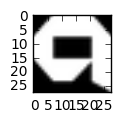

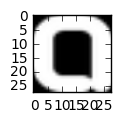

Found 52912 samples for letter C


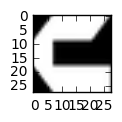

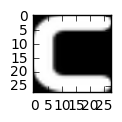

Found 52911 samples for letter J


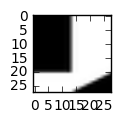

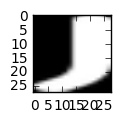

In [17]:
%pylab inline
pylab.rcParams['figure.figsize'] = (1, 1)

def display_sample_from_pickle(letter, pickle_file, max_samples=2):
    dataset = None
    with open(pickle_file, 'rb') as f:
        dataset = pickle.load(f)
    num_samples = dataset.shape[0]
    print("Found {0} samples for letter {1}".format(num_samples, letter))
    for i in range(max_samples):
        letter_data = dataset[i]
        letter_data = letter_data * pixel_depth + pixel_depth / 2
        plt.imshow(letter_data, cmap='gray')
        plt.show()

letters = ['A', 'C', 'J']
for letter in letters:
    display_sample_from_pickle(
        letter, 
        os.path.join('notMNIST_large', '{0}.pickle'.format(letter)))

---
Problem 3
---------
Another check: we expect the data to be balanced across classes. Verify that.

---

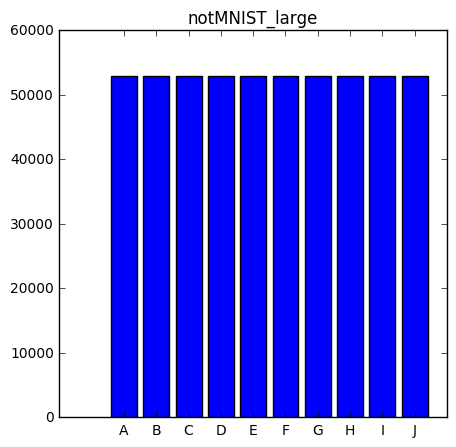

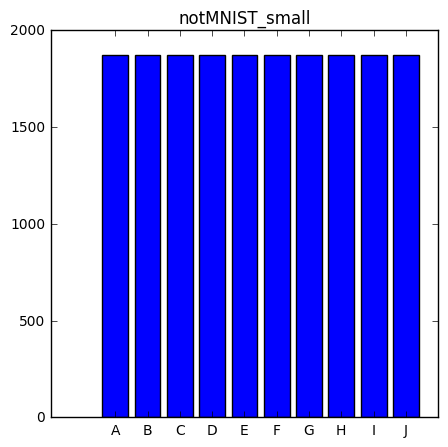

In [26]:
from glob import glob

pylab.rcParams['figure.figsize'] = (5, 5)

def dataset_size(pickle_file):
    with open(pickle_file, 'rb') as f:
        dataset = pickle.load(f)
        return dataset.shape[0]

def plot_dataset_size(base_dir):
    sizes = []
    classes = []
    for p_file in glob(os.path.join(base_dir, "*.pickle")):
        name, _ = os.path.splitext(os.path.basename(p_file))
        sizes.append(dataset_size(p_file))
        classes.append(name)
    x_pos = np.arange(len(sizes))
    plt.bar(x_pos, sizes, align="center")
    plt.xticks(x_pos, classes)
    plt.title(base_dir)
    plt.show()

plot_dataset_size("notMNIST_large")
plot_dataset_size("notMNIST_small")

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune `train_size` as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [28]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [29]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

---
Problem 4
---------
Convince yourself that the data is still good after shuffling!

---

Example 97482 for train:
Label 5 (letter F)


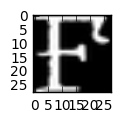

Example 4743 for train:
Label 5 (letter F)


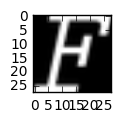

Example 177642 for train:
Label 7 (letter H)


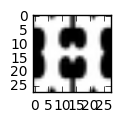

Example 5775 for validation:
Label 5 (letter F)


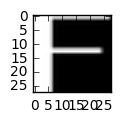

Example 1422 for validation:
Label 2 (letter C)


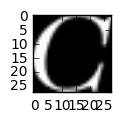

Example 9278 for validation:
Label 6 (letter G)


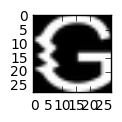

Example 8041 for test:
Label 6 (letter G)


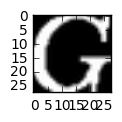

Example 3708 for test:
Label 0 (letter A)


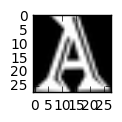

Example 9488 for test:
Label 4 (letter E)


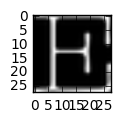

In [38]:
import string

pylab.rcParams['figure.figsize'] = (1, 1)

def print_examples(label, dataset, labels, num_examples=3):
    example_indexes = random.sample((num_examples,)) * dataset.shape[0]
    for example_index in example_indexes:
        example_index = int(example_index)
        print("Example {0} for {1}:".format(example_index, label))
        print("Label {0} (letter {1})".format(
            labels[example_index], string.ascii_uppercase[labels[example_index]]))
        letter_data = dataset[example_index]
        letter_data = letter_data * pixel_depth + pixel_depth / 2
        plt.imshow(letter_data, cmap='gray')
        plt.show()

print_examples("train", train_dataset, train_labels)
print_examples("validation", valid_dataset, valid_labels)
print_examples("test", test_dataset, test_labels)

Finally, let's save the data for later reuse:

In [39]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [40]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 690800512


---
Problem 5
---------

By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it.
Measure how much overlap there is between training, validation and test samples.

Optional questions:
- What about near duplicates between datasets? (images that are almost identical)
- Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.
---

### Problem 5 solution

First duplicates:

In [2]:
import pickle
train_dataset, valid_dataset, test_dataset = None, None, None

with open("notMNIST.pickle", "rb") as f:
    saved = pickle.load(f)
    train_dataset = saved['train_dataset']
    valid_dataset = saved['valid_dataset']
    test_dataset = saved['test_dataset']
    
train_dataset.sort(axis=0)
valid_dataset.sort(axis=0)
test_dataset.sort(axis=0)

In [7]:
import numpy as np
image_size = 28

def comp_datasets(d0, d1):
    nd_indexes_0 = []
    nd_indexes_1 = []
    i0, i1 = 0, 0
    while i0 < d0.shape[0] and i1 < d1.shape[0]:
        l0 = d0[i0].reshape(image_size * image_size)
        l1 = d1[i1].reshape(image_size * image_size)
        if np.all(np.equal(l0, l1)):
            i0 += 1
            i1 += 1
        else:
            idx = np.where((l0>l1)^(l0<l1) == True)[0][0]
            if l0[idx] < l1[idx]:
                nd_indexes_0.append(i0)
                i0 += 1
            else:
                nd_indexes_1.append(i1)
                i1 += 1
    while i0 < d0.shape[0]:
        nd_indexes_0.append(i0)
        i0 += 1
    while i1 < d1.shape[0]:
        nd_indexes_1.append(i1)
        i1 += 1
    return nd_indexes_0, nd_indexes_1

print("starting comparison")
train_valid_indices, valid_indices = comp_datasets(train_dataset, valid_dataset)
print(train_dataset.shape[0] - len(train_valid_indices))

starting comparison
2041


In [8]:
train_test_indices, test_indices = comp_datasets(train_dataset, test_dataset)
print(train_dataset.shape[0] - len(train_test_indices))

1808


So, looks like we have 2,041 examples that are identical between the train and valid datasets, and 1,808 identical between the train and test dataset. Wow, that is a lot of identical examples!

These comparisons took at least 5 seconds to run, which means that the 2 billion pairwise comparisons required for a brute-force determination of similarity would take about two days to execute. Since that's too long, we're going to use a little trick: we're going to identify near-duplicates using the [bit sampling method](https://en.wikipedia.org/wiki/Locality-sensitive_hashing#Bit_sampling_for_Hamming_distance).

### Near-Duplicates

First we're going to eliminate duplicates and add an index we can use to identify elements:

In [24]:
import random

def indexed_distinct(d, indices):
    distinct = d.reshape(d.shape[0], image_size * image_size).take(indices, axis=0)
    indices_col = np.arange(distinct.shape[0], dtype=distinct.dtype).reshape(distinct.shape[0], 1)
    return np.hstack((distinct, indices_col))

def permutations(size, num):
    nums = list(range(size))
    random.shuffle(nums)
    seg_size = size // num
    seg_remainder = size % num
    perms = []
    last_index = 0
    for i in range(num):
        size = seg_size
        if seg_remainder > 0:
            size += 1
            seg_remainder -= 1
        perms.append(nums[last_index:last_index + size] + nums[last_index + size:] + nums[:last_index])
        last_index += size
    return perms

permutations(13, 4)

[[5, 6, 9, 7, 0, 3, 4, 8, 11, 12, 2, 1, 10],
 [0, 3, 4, 8, 11, 12, 2, 1, 10, 5, 6, 9, 7],
 [8, 11, 12, 2, 1, 10, 5, 6, 9, 7, 0, 3, 4],
 [2, 1, 10, 5, 6, 9, 7, 0, 3, 4, 8, 11, 12]]

As you can see, the idea behind `permutations` is that we come up with `num` permutations of `size` numbers, where the first `ceil(size/num)` are different for each permutation, and we really don't care about the rest of the numbers, honestly.

In [31]:
def permuted(d, permutation):
    new_d = np.zeros(d.shape)
    for i in range(d.shape[0]):
        for j in range(d.shape[1] - 1):
            new_d[i, j] = d[i, permutation[j]]
        new_d[i, d.shape[1] - 1] = d[i, d.shape[1] - 1]
    return new_d

# testing
arr = np.random.choice(30, (3,8))
print(arr)
perms = permutations(7, 3)
print(permuted(arr, perms[0]))

[[29  6  3 21 28 26 21 26]
 [16 17 15 20  3 18 26  6]
 [22 12 27 15 11 11  9 18]]
[[  6.  21.  28.  29.  26.  21.   3.  26.]
 [ 17.  26.   3.  16.  18.  20.  15.   6.]
 [ 12.   9.  11.  22.  11.  15.  27.  18.]]


In [42]:
def add_near_dupes(slice_identical, near_duplicates, threshold):
    for l0 in slice_identical[0]:
        for l1 in slice_identical[1]:
            if np.count_nonzero(l0[:-1] != l1[:-1]) <= threshold:
                near_duplicates.add((l0[-1], l1[-1]))

def near_duplicates(d0, d1, permutation, slice_size, threshold):
    near_duplicates = set()
    d0 = permuted(d0, permutation)
    d1 = permuted(d1, permutation)
    d0.sort(axis=0)
    d1.sort(axis=0)
    i0, i1 = 0, 0
    while i0 < d0.shape[0] and i1 < d1.shape[0]:
        l0 = d0[i0]
        l1 = d1[i1]
        l0slice = l0[:slice_size]
        l1slice = l1[:slice_size]
        if np.all(np.equal(l0slice, l1slice)):
            slice_identical = ([l0], [l1])
            i0 += 1
            i1 += 1
            while i0 < d0.shape[0] and np.all(np.equal(d0[i0][:slice_size], l0slice)):
                slice_identical[0].append(d0[i0])
                i0 += 1
            while i1 < d1.shape[0] and np.all(np.equal(d1[i1][:slice_size], l1slice)):
                slice_identical[1].append(d1[i1])
                i1 += 1
            add_near_dupes(slice_identical, near_duplicates, threshold)
        else:
            idx = np.where((l0slice>l1slice)^(l0slice<l1slice) == True)[0][0]
            if l0slice[idx] < l1slice[idx]:
                i0 += 1
            else:
                i1 += 1
    return near_duplicates

# testing
permutation = [5, 2, 4, 3, 1, 0]
d0 = np.array([[2.0, 1.5, 2.2, 2.3, 2.4, 2.4, 3],
               [1.0, 1.5, 1.2, 1.3, 1.4, 1.4, 1], 
               [1.0, 1.8, 1.2, 1.3, 1.5, 1.4, 2]])
d1 = np.array([[1.0, 1.5, 1.2, 1.3, 1.5, 1.4, 1], 
               [2.0, 1.5, 2.2, 2.5, 2.4, 2.4, 3]])
print(near_duplicates(d0, d1, permutation, 2, 3))

{(1.0, 1.0), (2.0, 1.0), (3.0, 3.0)}


In [45]:
def all_near_duplicates(d0, d1, threshold):
    perms = permutations(image_size * image_size, threshold + 1)
    near_duplicate_set = set()
    for i, perm in enumerate(perms):
        print("On permutation {0}".format(i))
        near_duplicate_set |= near_duplicates(
            d0, d1, perm, (image_size * image_size) // (threshold + 1), 
            threshold)
    return near_duplicate_set

train_valid_indexed_distinct = indexed_distinct(train_dataset, train_valid_indices)
valid_indexed_distinct = indexed_distinct(valid_dataset, valid_indices)

In [46]:
near_valid_duplicates = all_near_duplicates(
    train_valid_indexed_distinct, 
    valid_indexed_distinct, 
    10)

On permutation 0
On permutation 1
On permutation 2
On permutation 3
On permutation 4
On permutation 5
On permutation 6
On permutation 7
On permutation 8
On permutation 9
On permutation 10


In [53]:
near_valid_duplicates = list(near_valid_duplicates)
near_valid_duplicates.sort()
near_valid_duplicates[:10]

[(0.0, 0.0),
 (0.0, 1.0),
 (0.0, 2.0),
 (0.0, 3.0),
 (0.0, 4.0),
 (0.0, 5.0),
 (0.0, 6.0),
 (0.0, 7.0),
 (0.0, 8.0),
 (0.0, 9.0)]

In [57]:
train_test_indexed_distinct = indexed_distinct(train_dataset, train_test_indices)
test_indexed_distinct = indexed_distinct(test_dataset, test_indices)

---
Problem 6
---------

Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

---

In [61]:
train_dataset, train_labels, test_dataset, test_labels = None, None, None, None

with open("notMNIST.pickle", "rb") as f:
    saved = pickle.load(f)
    train_dataset = saved['train_dataset']
    train_labels = saved['train_labels']
    test_dataset = saved['test_dataset']
    test_labels = saved['test_labels']

In [93]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

Y_test = LabelBinarizer().fit_transform(test_labels)
X_test = test_dataset.reshape((test_dataset.shape[0], 28 * 28))

def make_classifier_report(num_samples, C=None):
    Y_train = LabelBinarizer().fit_transform(train_labels[:num_samples])
    X_train = train_dataset.reshape((train_dataset.shape[0], 28 * 28))[:num_samples]
    classifier = None
    if C is not None:
        classifier = OneVsRestClassifier(LogisticRegression(n_jobs=-1, C=C))
    else:
        params = [{'estimator__C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]}]
        classifier = GridSearchCV(
            OneVsRestClassifier(LogisticRegression(n_jobs=-1)), 
            param_grid=params, scoring='f1_samples', n_jobs=-1, cv=5)
    classifier.fit(X_train, Y_train)
    if C is None:
        print(classifier.best_params_)
    Y_pred = classifier.predict(X_test)
    return classification_report(Y_test, Y_pred)

In [94]:
print(make_classifier_report(50))

/usr/local/var/pyenv/versions/3.5.2/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/var/pyenv/versions/3.5.2/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/var/pyenv/versions/3.5.2/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/var/pyenv/versions/3.5.2/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predict

{'estimator__C': 0.3}
             precision    recall  f1-score   support

          0       0.45      0.60      0.52      1000
          1       0.19      0.46      0.26      1000
          2       0.11      0.10      0.10      1000
          3       0.14      0.11      0.12      1000
          4       0.19      0.51      0.28      1000
          5       0.28      0.53      0.36      1000
          6       0.27      0.65      0.39      1000
          7       0.53      0.46      0.49      1000
          8       0.52      0.73      0.61      1000
          9       0.48      0.74      0.58      1000

avg / total       0.32      0.49      0.37     10000



In [95]:
print(make_classifier_report(100))

/usr/local/var/pyenv/versions/3.5.2/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/var/pyenv/versions/3.5.2/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/var/pyenv/versions/3.5.2/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/usr/local/var/pyenv/versions/3.5.2/lib/python3.5/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predict

{'estimator__C': 1}
             precision    recall  f1-score   support

          0       0.70      0.83      0.76      1000
          1       0.34      0.36      0.35      1000
          2       0.59      0.63      0.61      1000
          3       0.72      0.75      0.74      1000
          4       0.35      0.60      0.44      1000
          5       0.50      0.63      0.56      1000
          6       0.47      0.59      0.52      1000
          7       0.54      0.48      0.51      1000
          8       0.62      0.66      0.64      1000
          9       0.65      0.80      0.71      1000

avg / total       0.55      0.63      0.58     10000



In [96]:
print(make_classifier_report(1000, C=1.0))

             precision    recall  f1-score   support

          0       0.88      0.83      0.85      1000
          1       0.83      0.76      0.79      1000
          2       0.81      0.80      0.80      1000
          3       0.87      0.83      0.85      1000
          4       0.73      0.68      0.70      1000
          5       0.86      0.77      0.81      1000
          6       0.83      0.78      0.80      1000
          7       0.86      0.79      0.82      1000
          8       0.72      0.75      0.73      1000
          9       0.83      0.80      0.81      1000

avg / total       0.82      0.78      0.80     10000



In [97]:
print(make_classifier_report(5000, C=1.0))

             precision    recall  f1-score   support

          0       0.88      0.83      0.86      1000
          1       0.87      0.79      0.83      1000
          2       0.88      0.84      0.86      1000
          3       0.91      0.84      0.87      1000
          4       0.79      0.70      0.74      1000
          5       0.87      0.83      0.85      1000
          6       0.86      0.81      0.84      1000
          7       0.87      0.80      0.83      1000
          8       0.77      0.79      0.78      1000
          9       0.86      0.83      0.84      1000

avg / total       0.86      0.81      0.83     10000

